#### Libraries and Packages

In [1]:
import os
import numpy as np
import pandas as pd
import math
import random
import time
from matplotlib import pyplot as plt
from surprise import KNNWithMeans
from surprise.model_selection.validation import cross_validate
from surprise import Dataset
from surprise import Reader
import findspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
# Set spark environments
os.environ['PYSPARK_PYTHON'] = '/Users/nehapusarla/anaconda3/bin/python3.7'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/Users/nehapusarla/anaconda3/bin/python3.7'

In [2]:
file = "/Users/nehapusarla/Documents/IEORE4571/ratings.csv"

## Exploratory Data Analysis and Sampling 

In [3]:
data = pd.read_csv(file)

In [4]:
data.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [6]:
user_df = data.groupby('userId').count()[['movieId']].rename(columns={'movieId':'ratings_count'})
user_df.head()

,ratings_count
userId,
1,16
2,15
3,11
4,736
5,72


In [7]:
avg_rating = data.groupby('userId').mean()['rating']
user_df['average_rating'] = avg_rating
user_df = user_df.reset_index()
user_df.head()

,userId,ratings_count,average_rating
0,1,16,3.312500
1,2,15,3.666667
2,3,11,3.545455
3,4,736,3.397418
4,5,72,4.263889


In [8]:
print("Number of users:", len(user_df))

Number of users: 283228


In [9]:
movie_df = data.groupby('movieId').count()[['userId']].rename(columns={'userId':'ratings_count'})
movie_df.head()

,ratings_count
movieId,
1,68469
2,27143
3,15585
4,2989
5,15474


In [10]:
avg_movie_rating = data.groupby('movieId').mean()['rating']
movie_df['average_movie_rating'] = avg_movie_rating
movie_df = movie_df.reset_index()
movie_df.head()

,movieId,ratings_count,average_movie_rating
0,1,68469,3.886649
1,2,27143,3.246583
2,3,15585,3.173981
3,4,2989,2.874540
4,5,15474,3.077291


In [11]:
print("Number of users: ", len(movie_df))

Number of users:  53889


From observing the data, we see there are 283,228 unique users and 53889 unique movies. We will want to train our model on around 20,000 users and 1,000 movies. Hence we will set conditions based on our business objectives to narrow down our selection before randomly sampling to a smaller dataset.

### Finding Sampling Thresholds 

To sample the dataset, we took some rules that we mentioned above under Framework into consideration. Firstly, we mentioned that our intended user were existing, active users. Therefore, the first step to sampling our dataset is to find the threshold of the number of movies a user has rated that separates them from an inactive user to an active user. 

In [12]:
user_df.head()

,userId,ratings_count,average_rating
0,1,16,3.312500
1,2,15,3.666667
2,3,11,3.545455
3,4,736,3.397418
4,5,72,4.263889


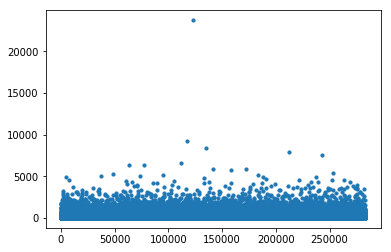

In [13]:
plt.scatter(user_df['userId'], user_df['ratings_count'], s=10);

We decided that this did not provide enough information for our analysis and thus, we took another step to group the number of ratings to see how many users rated a certain number of movies. 

Text(0.5, 0, 'number of ratings')

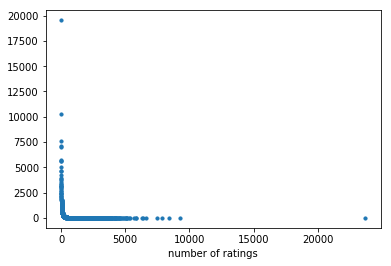

In [14]:
fig = plt.figure()
temp = user_df.groupby('ratings_count').count().reset_index().rename(columns={'userId': 'count'})
plt.scatter(temp['ratings_count'], temp['count'], s = 10)
plt.xlabel('number of ratings')

Majority of users rated under 5000. There seems to be outliers who did over 5000 ratings. Since, the distribution in the earlier number of ratings is not clear, we zoomed into that section. 

In [15]:
less_ratings = user_df[user_df['ratings_count'] < 30]

Text(0.5, 0, 'number of ratings')

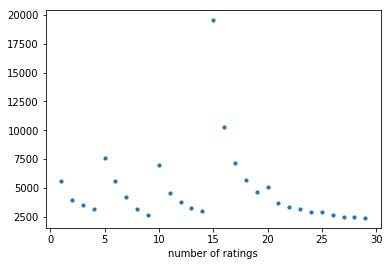

In [16]:
fig = plt.figure()
temp2 = less_ratings.groupby('ratings_count').count().reset_index().rename(columns={'userId': 'count'})
plt.scatter(temp2['ratings_count'], temp2['count'], s = 10)
plt.xlabel('number of ratings')

In [17]:
user_df['ratings_count'].describe()

count    283228.000000
mean         97.989761
std         212.760722
min           1.000000
25%          15.000000
50%          30.000000
75%          95.000000
max       23715.000000
Name: ratings_count, dtype: float64

Most users submit around 15 ratings. The number of users then slowly decreases as number of ratings continue to increase past 30. Our business objective focuses on active users and bettering their experience. In addition, we do not want the data to be too sparse in ratings made. For this current model, we are only training on the users and their ratings, hence, we want to select users with many ratings to make the dataframe more dense.

Hence, we will limit to sampling from users who have at least rated 15 movies and at most 3000.

The next step in sampling our dataset, is focusing on popular movies, or those that have been rated a certain number of times. Our theory in working with popular movies comes from the fact that popular movies means that they have more ratings, and more information to work with. If a movie does not have many ratings, it is difficult to tell what kind of users like that movie. In addition, since it has a smaller dataset of users, the average ratings don't hold as much value as those that have been watched and rated by many people, making it difficult to know whether that movie was actually highly rated or not. 

In [18]:
movie_df.head()

,movieId,ratings_count,average_movie_rating
0,1,68469,3.886649
1,2,27143,3.246583
2,3,15585,3.173981
3,4,2989,2.874540
4,5,15474,3.077291


The movie_df dataset above shows the number of ratings per movieId. For example, movieId: 1 has 68,469 ratings. We wanted to take this one step further by grouping the ratings, and visualizing how many groups of a certain number of ratings there are. For instance, how many movies have around 68,000 ratings? 

In [19]:
movie_freq = movie_df.groupby(['ratings_count']).count()['movieId']
movie_freq = movie_freq.reset_index().rename(columns={'movieId': 'count'})
movie_freq.head() 

,ratings_count,count
0,1,10155
1,2,6324
2,3,3919
3,4,2667
4,5,2033


The movie_freq dataset has been updated to show the number of movies that have a certain number of ratings. In this scenario, there are 10,155 movies that only have 1 rating. 

Text(0, 0.5, 'Count')

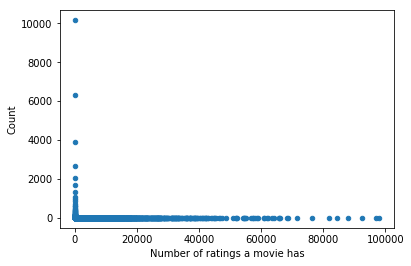

In [20]:
ax = movie_freq.plot.scatter(x='ratings_count', y='count')
ax.set_xlabel("Number of ratings a movie has")
ax.set_ylabel("Count")

To visualize the updated movie_freq dataset, we plotted a scatterplot to get a better idea of the frequency of the number of ratings a movie has. Since, this scatterplot does not reveal much information, we decided to zoom into it to clearly see the pattern around the 0 tick on the x-axis. 

Text(0, 0.5, 'Count')

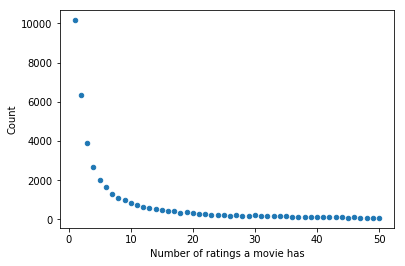

In [21]:
movie_small = movie_freq[movie_freq['ratings_count'] <= 50]
ax = movie_small.plot.scatter(x='ratings_count', y='count')
ax.set_xlabel("Number of ratings a movie has")
ax.set_ylabel("Count")

As seen from this scatterplot, there is no specific trend that seems to be clear, other than that there is a large amount of users that have rated between 0-10 movies. Due to the depth of this dataframe, since our movie database extends past 50,000 movies, we decided we cannot choose movies that have only 0-10 ratings, as it will result in a very sparse matrix. Therefore, we decided to go about another visualization trend to understand where the pattern of the number of ratings each movie has. 

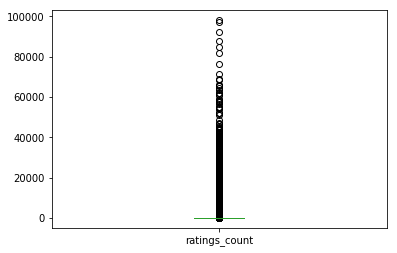

In [22]:
boxplot = movie_df.boxplot(grid=False, column='ratings_count')

Because this boxplot does not tell us much information as well, we are going to use the five number summary to extract more information. 

In [23]:
movie_df['ratings_count'].describe()

count    53889.000000
mean       515.011301
std       2934.758939
min          1.000000
25%          2.000000
50%          7.000000
75%         48.000000
max      97999.000000
Name: ratings_count, dtype: float64

This summary shows that the mean number of ratings is 515, and the maximum number of ratings is 97,999. In order to make more sense from this summary, we looked at the percentile distributions, since the mean can be heavily influenced by the outliers in this data. The percentile distribution shows that 50% of the movies have more than 7 ratings, and that 25% of the movies have more than 48 ratings. In order to sample this dataset down greatly to something that we can run on our system, we decided that we are going to work with the top 25% of the data, and set popular movies to those that have been rated at least 48 times. 

In addition, we mentioned that we want to recommend good movies to our customers. Our analyses of what is considered a "good" movie is going to be done here, although it will not be implemented while sampling the dataset, rather while extracting the top 10 movies to recommend to the customer

Text(0.5, 1.0, 'average ratings for users')

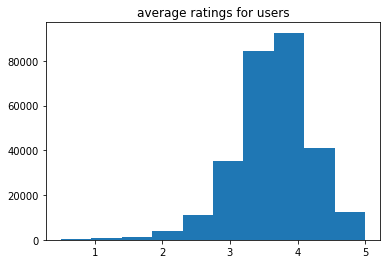

In [24]:
plt.hist(user_df['average_rating']);
plt.title("average ratings for users")

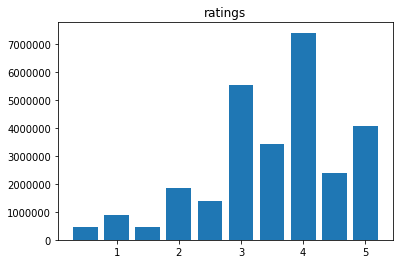

In [25]:
fig = plt.figure()
g = data.groupby('rating').count().reset_index();
x = g['rating']
y = g['userId']
plt.bar(x, y, width = 0.4);
plt.title("ratings");

In [26]:
data['rating'].describe()

count    2.775344e+07
mean     3.530445e+00
std      1.066353e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

The 2 plots are quite similar. We see through the bottom plots that more people give whole value numbers rather than halves. In addition, most people vote 4. The average rating given to a user is more normal. But similarly, most people's average ratings are around 3.5 to 4. Hence, when we determine whether or not a recommendation is "good", we will only consider values equal or greater than 3.5. This boundary will determine our accuracy in future parts of the project.

### Sampling

We are initially randomly cutting our dataset down to five percent of the original data to work with a dataset that can be run on our computers. 

In [4]:
data_sample = data.sample(frac=0.05)

Next, using this dataset, we are going to sample it down to the parameters established above in order to stay in line with our business objective. 

In [5]:
def sample_dataset(data, min_rated, user_min, user_max):
    grouped_user = data.groupby(['userId']).count()
    better_users = grouped_user[(grouped_user['rating'] > user_min) & (grouped_user['rating'] < user_max)].reset_index()['userId']
    rated_data = data[data['userId'].isin(better_users)]
    #min times rated
    group_times_rated = rated_data.groupby(['movieId']).count()
    better_movies_2 = group_times_rated[group_times_rated['userId'] > min_rated].reset_index()['movieId']
    rated_data_2 = rated_data[rated_data['movieId'].isin(better_movies_2)]
    return rated_data_2

In [6]:
data_sample = sample_dataset(data_sample, 48, 15, 3000)

In [7]:
print(len(data_sample))

556218


In [8]:
print("Number of users:", data_sample['userId'].nunique())
print("Number of movies:", data_sample['movieId'].nunique())

Number of users: 21381
Number of movies: 3138


Split into training and test data: 80% training and 20% testing. 

In [9]:
def train_test_split(data, test_percent):
    test_df = pd.DataFrame() #new testing dataframe created with holdout values
    users = [] 
    movies = [] 
    ratings = [] 
    for user, row in data.iterrows():
        row = row.dropna().reset_index()
        movieIds = list(row['movieId'])
        holdouts = int(test_percent * len(row))
        indices = random.sample(range(0, len(movieIds)), holdouts)
        for index in indices: 
            movieId = movieIds[index]
            ratings.append(data[movieId][user])
            data[movieId][user] = float("nan") #set value to nan for training matrix 
            users.append(user)
            movies.append(movieId)

    #create test dataframe 
    test_df['userId'] = users
    test_df['movieId'] = movies
    test_df['rating'] = ratings
    
    return data, test_df

In [10]:
df_sample = data_sample.pivot(index='userId', columns='movieId', values='rating')
training, test_df = train_test_split(df_sample, 0.2)

In [11]:
#convert training matrix to long dataframe for cross-validation purposes later 
def training_long(matrix):
    training_df = pd.DataFrame() #new testing dataframe created with holdout values
    users = [] 
    movies = [] 
    ratings = [] 
    for user, row in matrix.iterrows():
        row = row.dropna().reset_index()
        movieIds = list(row['movieId'])
        for movie in movieIds: 
            ratings.append(training[movie][user])
            users.append(user)
            movies.append(movie)

    #create training dataframe 
    training_df['userId'] = users
    training_df['movieId'] = movies
    training_df['rating'] = ratings
    return training_df

In [12]:
training_df = training_long(training)
#create a smaller development dataset to sanity check methods with 1,000 users 
df_dev = training.sample(n=1000, random_state = 1, axis = 0)

## Brute Force Collaborative Filtering Methods

### Item-based Collaborative Filtering
#### Model

In [13]:
#transpose the dataframe such that it is an item-user matrix
training_t = training.T
df_dev = df_dev.T
df_dev.head()

userId,187531,156201,260626,252826,140641,95236,172370,17045,11309,73652,...,76924,213867,224662,114370,128062,218489,54159,271240,185894,44359
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def find_averages(matrix):
    avg_dict = {}
    for index, user in matrix.iterrows():
        tot = 0
        length = 0
        for rating in user: 
            if not math.isnan(float(rating)):
                tot += rating 
                length += 1
                
        avg = tot/length 
        avg_dict[index] = avg
        
    return avg_dict

In [15]:
train_avg = find_averages(training_t)

In [16]:
def pearson_corr(matrix, movie1, movie2, avg_list):
    tot_numerator = 0 
    tot_movie1_den = 0 
    tot_movie2_den = 0 
    for user in matrix: 
        if not math.isnan(float(matrix[user][movie1])) and not math.isnan(float(matrix[user][movie2])):
            movie1_user = matrix[user][movie1] - avg_list[movie1]
            movie2_user = matrix[user][movie2] - avg_list[movie2]
            tot_numerator += movie1_user * movie2_user
            tot_movie1_den += movie1_user ** 2
            tot_movie2_den += movie2_user ** 2
                   
    denominator = (tot_movie1_den * tot_movie2_den) ** (1/2)
    if denominator == 0: 
        return 0 
    sim = tot_numerator / denominator 
    return sim 

In [17]:
def topkNeighbors(matrix, user, movie, k, avg_list):
    sim_matrix = {} 
    user_df = matrix[user].dropna().reset_index() 
    for other_movie in user_df['movieId']:
        sim_uv = pearson_corr(matrix, other_movie, movie, avg_list)
        sim_matrix[other_movie] = sim_uv 
            
    sort_sims = sorted(sim_matrix.items(), key=lambda x: x[1], reverse=True)
    if len(sort_sims) < k:
        return sort_sims
    return sort_sims[:k]

In [18]:
def calculate_rating(matrix, user, movie, k, avg_list):
    num = 0 
    den = 0 
    topk = topkNeighbors(matrix, user, movie, k, avg_list) 
    for pair in topk: 
        num += pair[1] * (matrix[user][pair[0]]) 
        den += abs(pair[1])
            
    rating = num/den
    return rating

We tested our finalized calculate_rating method with a sample user and movieId to show that our method works. The reason we could not implement these methods in our further steps is due to time limitations and space constraints.

In [19]:
rating = calculate_rating(training_t, training_t.columns[1], training_t.index[1], 10, train_avg)
print(rating)

3.4585438473350134


We rewrote the item-based collaborative filtering model using the surprise package with their KNNWithMeans and cross-validate functions. 

In [13]:
def get_model_ib(training_df, k):
    moviescales = Reader(rating_scale=(0.5, 5.0))
    data_training = Dataset.load_from_df(training_df, moviescales)    
    trainset = data_training.build_full_trainset()
    knn_model = KNNWithMeans(sim_options = {'name':'pearson', 'user_based': False}, k=k)
    knn_model.fit(trainset)
    return knn_model 

In [14]:
def get_predictions(model, test_df):
    preds = [] 
    for index, row in test_df.iterrows(): 
        pred = knn_model.predict(row['userId'], row['movieId'], r_ui=row['rating'], verbose=False)
        preds.append(pred.est)
    
    return preds 

### Evaluation

### Cross Validation

In [16]:
def cross_valid_user(matrix, folds, k):
    percent = 1/folds 
    rmses = [] 
    #train = None 
    #holdout_dict = None
    for i in range(1, folds+1):
        train = matrix.copy()
        holdout_dict = {} 
        for user, row in matrix.iterrows(): 
            row = row.dropna().reset_index()
            movieIds = list(row['movieId'])
            holdouts = int(percent * len(row))
            indices = random.sample(range(0, len(movieIds)), holdouts)
            holdout_dict[user] = [] 
            for index in indices: 
                movieId = movieIds[index]
                #print(matrix[movieId][user])
                train[movieId][user] = float("nan")
                #print(matrix[movieId][user])
                holdout_dict[user].append(movieId)
        
        train = train.T
        diff_sq = []  
        avg_list = find_averages(train)
        for user in holdout_dict: 
            for movie in holdout_dict[user]:
                prediction = calculate_rating(matrix, user, movie, k, avg_list)
                #print("Prediction:", prediction)
                diff_sq.append((matrix[movie][user] - prediction) ** 2)
                #print("Difference:", diff_sq)
        
        
        rmse = (sum(diff_sq) / len(diff_sq)) ** (1/2)
        rmses.append(rmse)
        
        
    avg_rmse = sum(rmses)/len(rmses)           
    return avg_rmse

In [15]:
k_range = [2,4,6,10,50,100,500]

In [17]:
def hypertune(matrix, k_range, folds):
    rmse_list = [] 
    for k in k_range: 
        rmse = cross_valid_user(matrix, folds, k)   
        rmse_list.append(rmse)
        
    return rmse_list 

In [18]:
#rmse_list = hypertune(training, k_range, 5)

Our above cross-validation methods(using the methods we wrote) were taking too long, around upwards of 16 hours, and thus, we moved to using the surprise package model methods written above. 

In [19]:
#run on small dataset first to sanity check our cross-validation method 
scales = Reader(rating_scale=(0.5, 5.0))
small_training = training_df.sample(n=1000, random_state = 1, axis = 0)
training_dev = Dataset.load_from_df(small_training[['userId', 'movieId', 'rating']], scales)

In [20]:
rmses = []
for k in k_range:
    pearson = KNNWithMeans(k=k, sim_options = {'name':'pearson', 'user_based': False}) 
    results = cross_validate(pearson, training_dev, measures=['RMSE'], cv=10, verbose=False)
    rmses.append(np.mean(results['test_rmse']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In this next run of cross-validation, we use the whole training dataframe that we initialized under the Sampling section, to tune k: the neighborhood size. The RMSE is calculated as a primary metric to determine the best k for the model, and MAE is calculated to add any additional insight in the case that RMSE does not distinguish. 

In [21]:
data_training = Dataset.load_from_df(training_df[['userId', 'movieId', 'rating']], scales)

In [22]:
rmses2 = []
mae2 = []
for k in k_range:
    pearson = KNNWithMeans(k=k, sim_options = {'name':'pearson', 'user_based': False}) 
    results = cross_validate(pearson, data_training, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    rmses2.append(np.mean(results['test_rmse']))
    mae2.append(np.mean(results['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

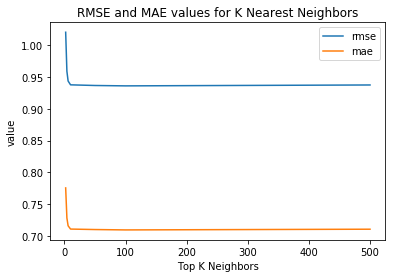

In [23]:
plt.figure()
plt.plot(k_range, rmses2, label = 'rmse')
plt.plot(k_range, mae2, label = 'mae')

plt.title("RMSE and MAE values for K Nearest Neighbors")
plt.xlabel("Top K Neighbors")
plt.ylabel("value")
plt.legend()
plt.show()

In [27]:
#get the min rmse value for KNN
rmse_min = 0
for i in range(len(rmses2)):
    if rmses2[i] < rmses2[rmse_min]: 
        rmse_min = i
        
print("K: " + str(k_range[rmse_min]) + ", RMSE: " + str(rmses2[rmse_min]))

K: 50, RMSE: 0.9358156095999292


As seen from the plot above, the RMSE and MAE metric follow similar patterns. There is a significant increase in accuracy between a 0-10 k value, and the accuracy levels out after, with very minor ups and downs. After finding the minimum RMSE value, we determined that setting the hyper-parameter to k=50 will be the best to proceed the rest of our model evaluations with. 

Even though RMSE is our primary evaluation metric, we took later metrics into account when determining k. When we set k=100 we noticed that our model is good at determining which movies that we recommend are truly good. However, it has difficulty at finding these relevant topics. In other words, it is not finding enough good recommendation which explains our initial low user coverage. Hence, we are using a smaller neighborhood size which will allow for more specific movie recommendations to the user rather than generalizing the preferences towards a popular vote.

### Accuracy Metrics

We will use the results from this model run in order to evaluate our accuracy metrics. 

In [28]:
#load the data into the surprise dataset 
data_training = Dataset.load_from_df(training_df, scales)   
trainset = data_training.build_full_trainset()

In [29]:
#build a KNN with means model using pearson corr as our similarity measure 
knn_model = KNNWithMeans(sim_options = {'name':'pearson', 'user_based': False}, k=50)
knn_model.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [30]:
preds = [] 
for index, row in test_df.iterrows(): 
    pred = knn_model.predict(row['userId'], row['movieId'], r_ui=row['rating'], verbose=False)
    preds.append(pred.est)

#### Error Metric

As mentioned above, the primary accuracy metric we are testing our whole dataset with is the root mean squared error. 

In [31]:
def get_rmse(pred, original):
    rmse = (sum((pred-original)**2)/len(pred)) ** (1/2)
    return rmse

In [33]:
#additional error metric
def get_mae(pred, original):
    mae = sum(abs(original - pred)) / len(pred)
    return mae

In [34]:
rmse = get_rmse(preds, test_df['rating'])
mae = get_mae(preds, test_df['rating'])
print("RMSE for test holdouts:", rmse)
print("MAE for test holdoutes:", mae)

RMSE for test holdouts: 0.9091950316322946
MAE for test holdoutes: 0.6910941605600635


Root mean squared error calculates the standard deviation of the prediction errors. Ideally, we would like to have the RMSE as small as possible. In this scenario, our RMSE is so close to 1, where our data ranges on a scale from 1 to 5, meaning our predictions do not have a great accuracy. Predicting a movie to have a rating of 3.5 in the case that it actually is rated 2.5 is harmful to the company, because our system will recommend a movie that is not actually a good recommendation, reducing the trust the users have in our system to provide them with good content. 

Moving forward, we would like to tune our k(nearest neighbors) more thoroughly, testing a wide range of values, given extended time and space constraints. Having a more accurate k, will likely lead to a lower RMSE, and therefore, a higher accuracy in our predictions. 

#### Ranking Metric

The **secondary** accuracy metric is the ranking metric: precision and recall. Precision measures the truly relevant recommendations out of everything recommended. Recall represents the truly relevant recommendations out of all relevant items.

We consider a rating of 3.5 and above to be a "good" rating. From the analyses done in our exploratory section, we determine that majority of the ratings are around 3-4, with around the top 25% of the ratings 4 or higher. Therefore, for users to consider a movie good, or one of the top movies out of the movies they've rated, we set the cutoff at 3.5 to distinguish it as good. From previous testing, we notice that setting a cutoff of 4 was too stringent and we would not recommend enough "good" movies. Hence, we think that 3.5 would be more suitable.

In [36]:
#rewrite the actual ratings and predictions into two categories 
test_df_ratings = pd.DataFrame()
test_df_ratings['prediction'] = preds
test_df_ratings['actual'] = np.where(test_df['rating'] >= 4, 1, 0)
test_df_ratings['prediction'] = np.where(test_df_ratings['prediction'] >= 4, 1, 0) 
test_df_ratings.head()

,prediction,actual
0,0,1
1,0,1
2,0,0
3,0,0
4,1,0


In [37]:
#determine the number of true positives in the matrix 
def tp(matrix):
    tp = 0
    for i in range(len(matrix)):
        if matrix['actual'][i] == 1 & matrix['prediction'][i] == 1:
            tp += 1
    return tp

In [38]:
precision = tp(test_df_ratings) / sum(test_df_ratings['prediction'])
print("Precision of test holdouts:", precision)
recall = tp(test_df_ratings) / sum(test_df_ratings['actual'])
print("Recall of test holdouts:", recall)

Precision of test holdouts: 0.7478874466416935
Recall of test holdouts: 0.3688190058856382


From our results above, the precision is relatively high. Even though recall is low, it is not as much of a concern. The high precision indicates that the recommendations our users recieve our mostly relevant. The low recall indicates there are many unexplored relevant movies that our model does not capture. This can be explored further with analyses on novelty and serendipity.

### Coverage

In [39]:
def get_top_recs_ib(ratings, preds, n):
    #returns the top n recommendations 
    top_recs = {}
    
    for index, row in ratings.iterrows():
        if row['userId'] not in top_recs.keys():
            top_recs[row['userId']] = [(row['movieId'], preds[index], row['rating'])]
        else:
            top_recs[row['userId']].append((row['movieId'], preds[index], row['rating']))
    
    # sort the preds for each user and get the n highest ones.
    for user, ratings in top_recs.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        top_recs[user] = ratings[:n]

    return top_recs

In [40]:
def user_coverage(top_recs, k):
    user_cov = {}
    tot = 0
    for user in top_recs:
        user_cov[user] = []
        for ratings in top_recs[user]:
            if ratings[2] >= 3.5:
                user_cov[user].append(ratings[0])
        if len(user_cov[user]) >= k:
            tot += 1
    return tot 

In [41]:
def item_coverage(top_recs, k):
    item_cov = {}
    tot = 0
    for user in top_recs:
        for ratings in top_recs[user]:
            if ratings[0] not in item_cov.keys(): 
                item_cov[ratings[0]] = [] 
            if ratings[2] >= 3.5:
                item_cov[ratings[0]].append(ratings[0])  
                
    for item in item_cov:
        if len(item_cov[item]) >= k:
            tot += 1        
    return tot, item_cov

In [42]:
top_recs_test = get_top_recs_ib(test_df, preds, 10)
user_cov_test = user_coverage(top_recs_test, 5) / len(top_recs_test)
print ("User Coverage of test set:", user_cov_test)
item_cov_ts, item_dict_ts = item_coverage(top_recs_test, 5)
item_cov_test = item_cov_ts / len(item_dict_ts)
print ("Item Coverage of test set:", item_cov_test)

User Coverage of test set: 0.1525780920713717
Item Coverage of test set: 0.8168253968253968


In [43]:
#decide to test on a range of k "well" users/items
k = [4, 5, 6, 7, 8, 9, 10, 15] 
user_covs_test = []
item_covs_test = [] 

for num in k: 
    user_cov_test = user_coverage(top_recs_test, num) / len(top_recs_test)
    user_covs_test.append(user_cov_test)
    item_cov_ts, item_dict_ts = item_coverage(top_recs_test, num)
    item_cov_test = item_cov_ts / len(item_dict_ts)
    item_covs_test.append(item_cov_test) 

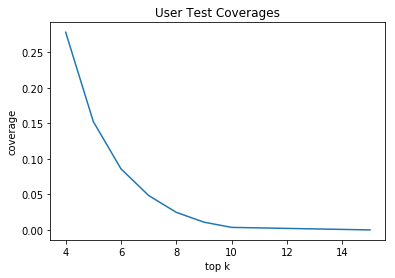

In [44]:
plt.figure()
plt.plot(k, user_covs_test)
plt.title("User Test Coverages")
plt.xlabel('top k')
plt.ylabel('coverage')
plt.show()

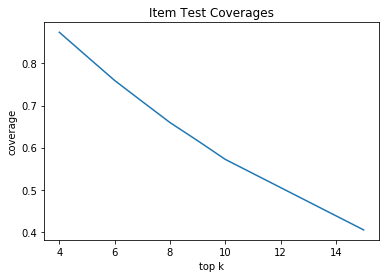

In [45]:
plt.figure()
plt.plot(k, item_covs_test)
plt.title("Item Test Coverages")
plt.xlabel('top k')
plt.ylabel('coverage')
plt.show()

As we increase k, the model becomes more stringent and the coverage understandably decreases. We see that item test coverage works much better than user coverage. This suggests that many of our items can be recommended well to at least k users. On the flip side, not many users are receiving at least k items in their top 10 list. This suggests that our model is not picking up the subtleties of each user and not catering to their tastes properly.

### Downsampling Evaluation

In [46]:
def downsampling(size):
    start_time = time.time()
    ds_data = data_sample.sample(frac=size)
    df_sample = ds_data.pivot(index='userId', columns='movieId', values='rating')
    training, test_df = train_test_split(df_sample, 0.2)
    training_df = training_long(training)
    model = get_model_ib(training_df, 100)
    preds = get_predictions(model, test_df)
    
    #get overall accuracy 
    rmse = get_rmse(preds, test_df['rating'])
    
    #get user coverage: how many good movies are recommended for each other 
    top_recs = get_top_recs_ib(test_df, preds, 10)
    user_cov = []
    for user in top_recs:
        tot = 0
        for ratings in top_recs[user]:
            if ratings[2] >= 3.5:
                tot += 1
        user_cov.append(tot/10)

    #get runtime 
    runtime = time.time() - start_time
    
    return rmse, user_cov, runtime 

In [47]:
sizes = [0.25, 0.5, 0.75, 1]
rmse_sizes = [] 
runtimes = [] 
user_covs = []
for size in sizes: 
    rmse, user_cov, runtime = downsampling(size)
    rmse_sizes.append(rmse)
    runtimes.append(runtime)
    user_covs.append(user_cov)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


Analyses on all following four plots is below. 

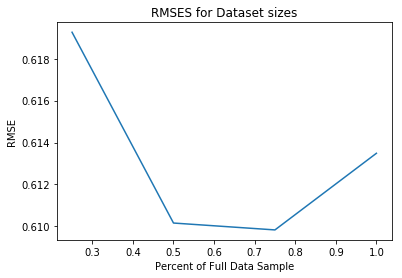

In [48]:
plt.figure()
plt.plot(sizes, rmse_sizes)
plt.title("RMSES for Dataset sizes")
plt.xlabel('Percent of Full Data Sample')
plt.ylabel('RMSE')
plt.show()

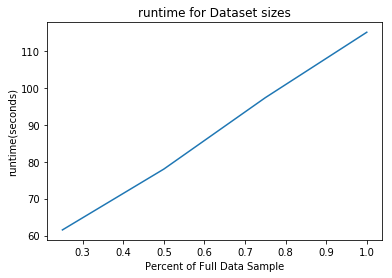

In [49]:
plt.figure()
plt.plot(sizes, runtimes)
plt.title("runtime for Dataset sizes")
plt.xlabel('Percent of Full Data Sample')
plt.ylabel('runtime(seconds)')
plt.show()

Text(0.5, 0, '% of Full Dataset')

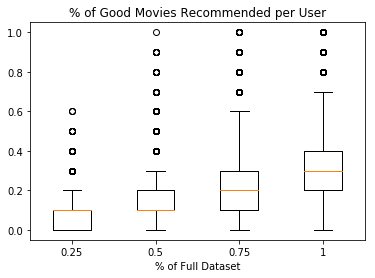

In [50]:
fig, ax = plt.subplots();
ax.boxplot(user_covs);
ax.set_xticklabels(['0.25', '0.5', '0.75', '1']);
ax.set_title("% of Good Movies Recommended per User")
ax.set_xlabel("% of Full Dataset")

We see that runtime drastically increases as we increase the proportion of data used for the model. RMSE decreases as we use more of the dataset. In addition, when we analyze the distribution of good recommendations over users, we see a clear increase as we increase the sample size. With all these put into consideration, we need to analyze the tradeoff to see how much of the data sample to use for this recommendation system. 

As of currently, this method needs more work before it can be implemented to meet our objective at a real company. Even though the item based coverage, RMSE, and MAE are not too bad, the user based coverage is quite low. This suggests that many users will not have a good user experience because they get recommended movies that they may not enjoy. We do see that decreasing the cutoff from 4 to 3.5 results in a drastically better coverage score for both user and item. However, we do not think such a cut off will be accurate because we want to recommend good movies rather than average movies.

Run time would definitely be an aspect to watch out for because as the amount of data we receive increases, the runtime of these models will increase as well.

In addition, we think it would be useful to tune the hyperparamters further on the ranking metrics such as user and item coverage, and precision and recall. The RMSEs have been very similar with different numbers of neighbors but coverage has varied greatly with our 2 tests of k of 50 and 100. We believe further testing neighborhood size with these coverage values would be very useful for the final model's viability.

Future topics we would look into would be implementing genres and other context based models into our prediction to help us better cater to the consumers tastes. This will help us improve the user based coverage. We believe that context will drastically help our recommendations because we can provide users with items that may be less novel but better rated.

Finally, we should not rely on the results of just one model, but create an ensemble with other methods as well. This way, the different models can target different aspects of the user to provide the best experience.

### Final Recommendation with Item-Based Collaborative Filtering

In [132]:
#create a dataframe for all the nan values to fill out for the final recommendation 
toFill = pd.DataFrame() 
userIds = [] 
movieIds = [] 
for movie in df_sample: 
    users = df_sample[movie].index 
    for user in users: 
        rating = df_sample[movie][user]
        if math.isnan(float(rating)): 
            userIds.append(user)
            movieIds.append(movie)
            
toFill['userId'] = userIds
toFill['movieId'] = movieIds

In [135]:
#add in the rating column
toFill['rating'] = [float('nan')] * len(toFill)
toFill.head()

,userId,movieId,rating
0,51,1,NaN
1,56,1,NaN
2,73,1,NaN
3,79,1,NaN
4,81,1,NaN


In [140]:
#train on the whole data sample(~20,000 users and ~3,000 movies)
#keep k = 100 as that was our best parameter 
#these are pretty big tasks so we are running them in different cells
data_sample = data_sample.drop(columns=['timestamp'])
model = get_model_ib(data_sample, 100)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [141]:
preds = get_predictions(model, toFill)

The top_recs dictionary below is our final recommendation to the manager, it has the top 10 recommended movies for each user in the sampled data. 

In [96]:
top_recs = get_top_recs(toFill, preds, 10) 

## Matrix Factorization

### Building of Feature Vector

In [52]:
findspark.init() 

In [53]:
sc = SparkContext('local')
spark = SparkSession(sc)

Using the data that has been sampled based on the conditions described above, we are going to resplit it into training and testing here because the way the data is split into training and testing is different with this model, though we are keeping consistent with the 80/20 training-testing split. 

In [54]:
ratings = spark.createDataFrame(data_sample)

In [55]:
training, test = ratings.randomSplit([0.8, 0.2])
print(len(training.collect()))
print(len(test.collect()))

445175
111796


### Model 

In [56]:
# Build the recommendation model using ALS on the training data
def get_mf_model(rank, regparam, ratings):
    als = ALS(maxIter=5, rank=rank, regParam=regparam, userCol="userId", itemCol="movieId", ratingCol="rating",
              coldStartStrategy="drop")
    model = als.fit(ratings)
    return model 

### Evaluation

The primary accuracy metric we are going to use to determine the best hyper-parameters for this model is the root mean squared error. The method to calculate the root mean squared error is outlined below. This method takes in the rank(number of latent factors) and regularization parameter because these are the two hyper-parameters that we are going to tune for the best results. 

In [14]:
def get_rmse_metric(rank, regparam, training, testing):
    model = get_mf_model(rank, regparam, training)
    predictions = model.transform(testing)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    return rmse 

### Cross Validation

In [72]:
def build_crossvalid_mf(folds, ratings, regParam, rank): 
    rmses = [] 
    weights = [1.0] * folds
    sets = ratings.randomSplit(weights)
    #create new test and training data frames for each fold 
    for i in range(0, folds):  
        training = spark.createDataFrame(sc.emptyRDD(), ratings.schema)
        test = sets[i]
        for j in range(0, folds):
            if i != j: 
                training = training.union(sets[j])
        
        rmse = get_rmse_metric(rank, regParam, training, test) 
        rmses.append(rmse)
        
    avg_rmse = sum(rmses)/len(rmses)
    return avg_rmse

In [58]:
rank_range = [1,2,3,4,5,6,7,8,9,10,50,100] #latent dimensions 
reg_range = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.25] #regularization parameter 

Instead of testing on a range of values that increment by a certain constant, for example, from 2 to 100 in increments of 2, we specified our own ranges for the rank and regularization parameters to be tested on in order to provide results under certain time constraints. Because time was a factor in performing the tuning of the hyper-parameters, we believe that the ranges we outlined would provide us with enough information about the model. 

In [61]:
def hypertuning_mf(ratings, rank_range, reg_range, folds):
    #hold one parameter constant by testing the range of the other parameter
    rmses_rank = {}
    for rank in rank_range: 
        rmse = build_crossvalid_mf(folds, ratings, 0.01, rank)
        print("Cross-validation done for rank:", rank)
        rmses_rank[rank] = rmse 
     
    rmses_reg = {}
    for reg in reg_range:
        rmse = build_crossvalid_mf(folds, ratings, reg, 10)
        print("Cross-validation done for reg:", reg)
        rmses_reg[reg] = rmse        
        
    return rmses_rank, rmses_reg

In order to tune two parameters within time contraints, we held one parameter constant while tuning the other hyper-parameter. While tuning rank, we set the regularization parameter to 0.01, and while tuning the regularization parameter, we set the rank to 10. Both of these parameters were set to the stated values because these values are the defaults that Spark uses when not specified. 

In [62]:
rmses_rank, rmses_reg = hypertuning_mf(training, rank_range, reg_range, 10)

Cross-validation done for rank: 1
Cross-validation done for rank: 2
Cross-validation done for rank: 3
Cross-validation done for rank: 4
Cross-validation done for rank: 5
Cross-validation done for rank: 6
Cross-validation done for rank: 7
Cross-validation done for rank: 8
Cross-validation done for rank: 9
Cross-validation done for rank: 10
Cross-validation done for rank: 50
Cross-validation done for rank: 100
Cross-validation done for reg: 0.0025
Cross-validation done for reg: 0.005
Cross-validation done for reg: 0.01
Cross-validation done for reg: 0.05
Cross-validation done for reg: 0.1
Cross-validation done for reg: 0.25


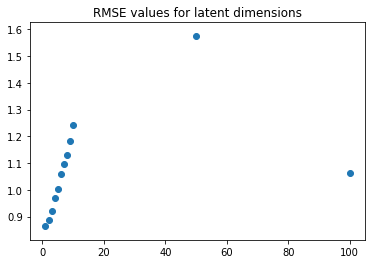

In [65]:
plt.figure()
plt.scatter(rmses_rank.keys(), rmses_rank.values())
plt.title("RMSE values for latent dimensions")
plt.show()

In [66]:
#get the min rmse value for rank 
rmse_min = list(rmses_rank.keys())[0]
for rank in rmses_rank: 
    if rmses_rank[rank] < rmses_rank[rmse_min]: 
        rmse_min = rank
        
print("Rank: " + str(rmse_min) + ", RMSE: " + str(rmses_rank[rmse_min]))

Rank: 1, RMSE: 0.8641217869495877


As seen from this plot, the data follows an approximate hyperbolic curve as the latent factors increase from 1 to 100. Around 50, a peak is reached in the RMSE, and the values go back down as seen by the RMSE at 100. The minimum RMSE value based on the plot is at 1 latent factor. 

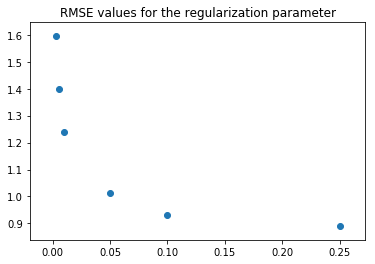

In [67]:
plt.figure()
plt.scatter(rmses_reg.keys(), rmses_reg.values())
plt.title("RMSE values for the regularization parameter")
plt.show()

In [68]:
#get the min rmse value for reg 
rmse_min = list(rmses_reg.keys())[0]
for reg in rmses_reg: 
    if rmses_reg[reg] < rmses_reg[rmse_min]: 
        rmse_min = reg
        
print("Reg Param: " + str(rmse_min) + ", RMSE: " + str(rmses_reg[rmse_min]))

Reg Param: 0.25, RMSE: 0.8894694338042489


From the plot seen above, the RMSE values as the regularization parameter increases appears to follow an approximate exponential distribution. As the value of the parameter increases, the RMSE greatly decreases, leaving the regularization parameter of 0.25 as having the minimum RMSE. 

After seeing these results, we noticed that we could perhaps further optimize this model by testing more regularization parameters. Since, the distribution leads us to believe that with an increased regularization parameter, the RMSE value decreases, we decided to test this with regularization parameters 0.5 and 1. The results are displayed below. 

In [71]:
#Try cross-valid for regParam 0.5 and 1.0 
rmse = build_crossvalid_mf(10, training, 0.5, 10)
print(rmse)
rmse = build_crossvalid_mf(10, ratings, 1.0, 10) 
print(rmse)

1.0058713622451443
1.3100318279298206


The RMSE values are already higher than the minimum found earlier, and thus we will keep 0.25 as our optimized regularization parameter. 

### Accuracy Metrics

We will use the results from this model run in order to evaluate our accuracy metrics. 

In [57]:
model = get_mf_model(1, 0.25, training)
predictions_train = model.transform(training)
predictions_test = model.transform(test)

#### Error Metric

As mentioned above, the primary accuracy metric we are testing our whole dataset with is the root mean squared error. 

In [58]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse_training = evaluator.evaluate(predictions_train)
rmse_test = evaluator.evaluate(predictions_test)
print("RMSE for Training:", rmse_training) 
print("RMSE for Test:", rmse_test)

RMSE for Training: 0.8529947839745184
RMSE for Test: 0.8931003288827825


The RMSE values for both the training and testing data are around the same, which is a good sign as that means we have not overfit or underfit the data with our model. But, the actual RMSE value itself can be improved. Since our data ranges from ratings 0 to 5, having an rmse around 20% of that range is a little high, and should be impvoed. 

#### Ranking Metric

The secondary accuracy metric we chose to evaluate the results from our "best" model is precision and recall. Based on the exploratory analysis done above, we decided that a rating of 3.5 is the appropriate cutoff to distinguish a "good" movie. 

In [59]:
#determine the number of true positives in the matrix  
def tp(matrix):
    good_preds = 0 
    good_actual = 0
    tp = 0
    for row in matrix.rdd.collect():
        if row['rating'] >= 3.5 and row['prediction'] >= 3.5:
            tp += 1
        if row['rating'] >= 3.5: 
            good_actual += 1
        if row['prediction'] >= 3.5: 
            good_preds += 1
            
    return tp, good_preds, good_actual 

In [60]:
tp_train, good_preds_train, good_actual_train = tp(predictions_train)
tp_test, good_preds_test, good_actual_test = tp(predictions_test)
precision_train = tp_train / good_preds_train 
print("Precision for Training:", precision_train)
recall_train = tp_train / good_actual_train 
print("Recall for Training:", recall_train)
precision_test = tp_test / good_preds_test
print("Precision for Test:", precision_test)
recall_test = tp_test / good_actual_test 
print("Recall for Test:", recall_test)

Precision for Training: 0.8822185292895721
Recall for Training: 0.4590427276522154
Precision for Test: 0.8514800514800515
Recall for Test: 0.44164898903739747


The precisions and recall values of both the training and testing follow the same pattern. The precision for both training and testing is quite high, while the recall is relatively low for both. We inferred that the high precision was a good sign, as the ratio of true positives is high, meaning that most of the "good" recommendations that the model predicted were also considered "good" movies by the users. 

On the other hand, the low recall shows that we weren't able to predict as many good movies as the users rated. Recall is important because we want to continuously provide our users with good recommendations, so it is crucial to provide a sufficient list of good movies. If the number of good movies we recommend decreases, then the users may start to use the platform less. 

### Coverage

As with precision and recall, we chose a rating of 3.5 and above to be considered a "good" recommendation to calculate our user and item coverage. 

In [61]:
def get_top_recs(predictions, n):
    #get the top recs for each user 
    top_recs = {}
    
    for row in predictions.rdd.collect():
        if row['userId'] not in top_recs.keys():
            top_recs[row['userId']] = [(row['movieId'], row['prediction'], row['rating'])]
        else:
            top_recs[row['userId']].append((row['movieId'], row['prediction'], row['rating']))
    
    # sort the preds for each user and get the n highest ones.
    for user, ratings in top_recs.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        top_recs[user] = ratings[:n]

    return top_recs

In [62]:
def user_coverage(top_recs, k):
    user_cov = {}
    tot = 0
    for user in top_recs:
        user_cov[user] = []
        for ratings in top_recs[user]:
            if ratings[2] >= 3.5:
                user_cov[user].append(ratings[0])
        if len(user_cov[user]) >= k:
            tot += 1
    return tot 

In [63]:
def item_coverage(top_recs, k):
    item_cov = {}
    tot = 0
    for user in top_recs:
        for ratings in top_recs[user]:
            if ratings[0] not in item_cov.keys(): 
                item_cov[ratings[0]] = [] 
            if ratings[2] >= 3.5:
                item_cov[ratings[0]].append(ratings[0])  
                
    for item in item_cov:
        if len(item_cov[item]) >= k:
            tot += 1        
    return tot, item_cov

Using the same model from above to predict our training and testing ratings, we returned the top 10 recommended movies for each user in the cell below. 

In [64]:
top_recs_training = get_top_recs(predictions_train, 10)
top_recs_test = get_top_recs(predictions_test, 10)

We calculated our user and item coverage based on how many values of k we were testing for that performed "well". 

In [65]:
k = [4, 5, 6, 7, 8, 9, 10]
user_covs_train = [] 
user_covs_test = []
item_covs_train = [] 
item_covs_test = [] 

for num in k: 
    user_cov_train = user_coverage(top_recs_training, num) / len(top_recs_training)
    user_cov_test = user_coverage(top_recs_test, num) / len(top_recs_test)
    user_covs_train.append(user_cov_train)
    user_covs_test.append(user_cov_test)
    item_cov_tr, item_dict = item_coverage(top_recs_training, num)
    item_cov_train = item_cov_tr / len(item_dict)
    item_cov_ts, item_dict_ts = item_coverage(top_recs_test, num)
    item_cov_test = item_cov_ts / len(item_dict_ts)
    item_covs_train.append(item_cov_train)
    item_covs_test.append(item_cov_test) 

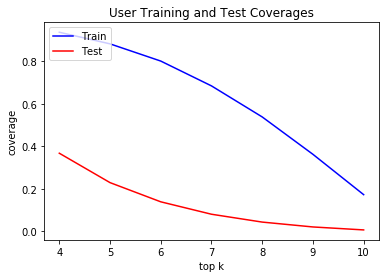

In [66]:
plt.figure()
plt.plot(k, user_covs_train, c="b", label='Train')
plt.plot(k, user_covs_test, c="r", label='Test')
plt.legend(loc="upper left")
plt.title("User Training and Test Coverages")
plt.xlabel('top k')
plt.ylabel('coverage')
plt.show()

As expected, the user training and testing coverages decreased as we increased k. But, there is a big discrepancy between the training and testing user coverages with the beginning values of k, mainly from 1 to 6. The coverage of the user training is a little over 2 times greater than that of the user testing, meaning that only 40% of the users will be satisfied with the recommendations we give them, since the testing dataset represents users that we have not seen before or trained on. The user coverage is something to work on as our goal is to maintain the satisfaction of all of our users. 

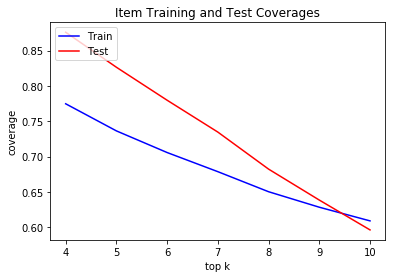

In [67]:
plt.figure()
plt.plot(k, item_covs_train, c="b", label='Train')
plt.plot(k, item_covs_test, c="r", label='Test')
plt.legend(loc="upper left")
plt.title("Item Training and Test Coverages")
plt.xlabel('top k')
plt.ylabel('coverage')
plt.show()

With our item coverage, both the training and testing data follow the same pattern as the k increases, and has around similar values for most values of k. While our item coverages on both training and testing sets reasonably decrease with the increase in k, it starts off with a much higher coverage than the user coverage. This suggests that many of our items can be recommended well to at least k users. On the other hand, not many users are receiving at least  k well items in their top 10 list. 

### Downsampling Evaluation

In [68]:
def downsampled_method(size):
    start_time = time.time() 
    ds_data = data_sample.sample(frac=size)
    ratings_ds = spark.createDataFrame(ds_data)
    training_ds, test_ds = ratings_ds.randomSplit([0.8, 0.2])
    model = get_mf_model(1, 0.25, training_ds)
    predictions = model.transform(test_ds)
    #get overall accuracy 
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    
    #get user coverage -> a version of user coverage: see how many good movies are recommended per user 
    top_recs = get_top_recs(predictions, 10)
    user_cov = []
    for user in top_recs:
        tot = 0 
        for ratings in top_recs[user]:
            if ratings[2] >= 3.5:
                tot += 1
        user_cov.append(tot/10)
    
    runtime = time.time() - start_time
    return rmse, user_cov, runtime 

In [69]:
sizes = [0.25, 0.5, 0.75, 1]
rmse_sizes = [] 
runtimes = [] 
user_covs = []
for size in sizes: 
    rmse, user_cov, runtime = downsampled_method(size)
    rmse_sizes.append(rmse)
    runtimes.append(runtime)
    user_covs.append(user_cov)

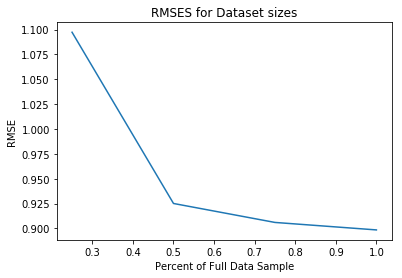

In [70]:
plt.figure()
plt.plot(sizes, rmse_sizes)
plt.title("RMSES for Dataset sizes")
plt.xlabel('Percent of Full Data Sample')
plt.ylabel('RMSE')
plt.show()

As shown from the plot above, overall accuracy does change with dataset size. The RMSE significantly decreased once there was enough data in the dataset, which according to the plot is around 50% of the full data sample. While the increase in accuracy isn't as high, from 50 to 100% of the full data sample, accuracy still slightly increases as the size of the dataset increases as well. Overall, it is safe to presume that the more information that the model has, the better it can perform. 

Text(0.5, 0, 'Percent of Full Data Sample')

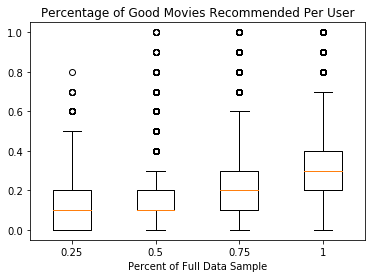

In [71]:
fig, ax = plt.subplots()
ax.boxplot(user_covs)
ax.set_xticklabels(["0.25", "0.5", "0.75", "1"])
ax.set_title("Percentage of Good Movies Recommended Per User")
ax.set_xlabel("Percent of Full Data Sample")

With this data, we wanted to see how the distribution of how many good movies are recommended for each user changes with the size of the dataset. With more data, the interquartile range of each boxplot increases as well. Therefore, this shows somewhat of a positive correlation such that with more data, the percentage of good movies recommended per user increases. But, something to notice is that the medians of 25% and 50% of the dataset are the same, while the there is a big jump between all the other categories. This could be due to the fact that even with the increase in information up to 50%, it wasn't enough information to recommend a higher percentage of good movies per user, the dataset was most likely still very sparse. Overall, we can see from this visualization that having more information in general, and a larger dataset, in general is better to predict more accurately and give better recommendations. More users get well recommended items, and this is what is necessary to keep users entertained, continue using the platform, and ideally share their content with the platform with friends and family as well. 

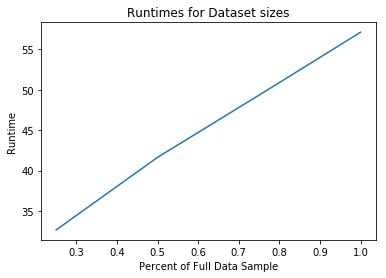

In [72]:
plt.figure()
plt.plot(sizes, runtimes)
plt.title("Runtimes for Dataset sizes")
plt.xlabel('Percent of Full Data Sample')
plt.ylabel('Runtime')
plt.show()

The output of this plot is expected, as data size increases, the runtime to perform calculations increases as well. 

Overall, this recommendation system can be improved. We would not feel comfortable putting these solutions into production at a real company, as it seems that our model can only recommend up to 20% movies that are considered "good", and realistically, the movies that we recommend should all be considered good. In addition, recall is low, and one of our objectives is to have a high precision and recall. The low recall shows how few movies the predicts as "good", which plays a role in the coverage calculations as well. Our model would have to be tuned such that it's rmse is lower, and its recall is higher. 

To implement in the future, we would like to add many more regularization parameters and latent dimensions to cross-validate and tune, given less time and space/ram constraints. We determined that one of the reasons our model was not doing as well as expected is because we were not confident in our parameters. With extensive testing, we can be confident that we chose the right hyper-parameters to output the best results. 

### Final Recommendation with Matrix Factorization

In [58]:
model = get_mf_model(1, 0.25, training)
predictions = model.transform(test)
top_recs = get_top_recs(predictions, 10)

The final recommendation is contained in this dictionary for 21,069 users. The key values are the userID, while the values include the top 10 recommended movies, along with their predicted ratings and actual ratings. 

In [63]:
top_recs

### Overall Analysis 

Now that we have evaluated both models thoroughly, the next step to tackle is to determine which method is more appropriate to make the final recommendation. When looking at both models during evaluating, both had similarities in that they had RMSEs around 0.8-0.9, which overall as mentioned can be better when working with a scale from 1-5. Both models had low user coverage, but high item coverage, and high precision, but low recall. When looking at both of the models from a high level, they had very similar accuracies and outputs. Although both models have similar statistics, they do not work well enough to be put into the production system to serve the customers as they do not capture the subtleties of each user. 

## Final Recommendation 

Given the overall analysis on these two models, it has been recognized that the output of one of these models alone does not work well enough. Thus, our final recommendation to the company would be to combine our results with those from a content-based model. Since a behavior-based model can provide new, but similar recommendations, while a content-based model can exploit the user's preferences to its benefit, the two combined will provide a reasonable mixture of movies to recommend such that the user can experience similarity and novelty within the recommendations, and be able to make the best use of this platform. 

### Disclaimer

The models built in this project focus on existing users and existing movies. If we want to target recommendations for new users and new movies, we would need to create a separate model for those cold start problems. 

In [ ]:
def content_based_model(movies_data, user_data):
    #build content analyzer for movies based on similar genre 

    #genres dataframe of movieIds 
    genres = pd.DataFrame() 
    genres['movieId'] = movies_data['movieId']
    for index, row in movies_data.iterrows(): 
        for genre in row['genres']:
            genres.at[index, genre] = 1

    #fill all the other NANs with 0 
    genres = genres.fillna(0)
    genres = genres.set_index(genres['movieId'])
    
    topMovies = {} 
    #building user preference profile of most liked genre for each user 
    for userId in user_data.userId.unique(): 
        ratings_user = user_data[user_data['userId'] == userId]
        user_genres = genres.loc[ratings_user['movieId']]
        user_genres.reset_index(drop=True, inplace=True)

        # get weights for user profile 
        ratings_user['weights'] = ratings_user['rating'] / 5
        user_profile = user_genres.T.dot(ratings_user['weights'].to_numpy())

        #get recommendations for user 
        recs = genres.dot(user_profile)
        recs.to_dict()
        recs = sorted(recs.items(), key=lambda x: x[1], reverse=True)

        #take top 10 
        recs = recs[:10]
        movieIds = [x[0] for x in recs]
        top_movies = movies_data[movies_data['movieId'].isin(movieIds)]['title']
        topMovies[userId] = top_movies
        
    return topMovies